## Table of content

| Chapter                                 | Description                                     |
|:----------------------------------------|:------------------------------------------------|
| [Main goal](#main-goal)                 | Describes the main goal of this notebook        |
| [Data description](#data-description)   | Describes data structure                        |
| [Statistic](#statistic)                 | Shows main characteristics of data              |
| [Plots](#plots)                         | Shows a big part of issues and patterns in data |
| [Pattern selection](#pattern-selection) | Summarizes patterns in data                     |
| [Potential issues](#potential-issues)   | Summarize issues in data                        |
| [Manual prediction](#manual-prediction) | Describe process of manual predicting           |
| [Conclusion](#conclusion)               | Summarize the whole notebook                    |

## Main goal

The main goal of this notebook is get data understanding, select patterns in the data, overthink preprocessing process and feature engineering, select potential problems and do manual prediction of the data.

## Data description

This dataset provides historical sales data for an e-commerce platform in Russia. It consists of five files containing information on items, categories, shops, and sales transactions from January 2013 to October 2015.

### File Descriptions:

`items.csv`

* `item_name`: `string` - Name of the good.
* `item_id`: `integer` - Primary key, a unique identifier for each item.
* `item_category_id`: `integer` - Foreign key linking to item_categories.csv.

`item_categories.csv`

* `item_category_name`: `string` - Name of the product category.
* `item_category_id`: `integer` - Primary key, a unique identifier for each category.

`shops.csv`

* `shop_name`: `string` - Name of the shop.
* `shop_id`: `integer` - Primary key, a unique identifier for each shop.

`sales_train.csv`

* `date`: `datetime` - Date of purchase in dd.mm.yyyy format.
* `date_block_num`: `integer` - A unique monthly identifier. January 2013 is 0, February 2013 is 1, and so on.
* `shop_id`: `integer` - Foreign key linking to shops.csv.
* `item_id`: `integer` - Foreign key linking to items.csv.
* `item_price`: `float` - The price of the item in Russian Rubles (RUB).
* `item_cnt_day`: `integer` - The number of units of the item sold on a specific day. This value can be negative due to returns.

In [59]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [4]:
df_train = pd.read_csv('data/full_train.csv')

In [6]:
df_train.columns

Index(['date', 'date_block_num', 'shop_id', 'item_id', 'item_price',
       'item_cnt_day', 'shop_name', 'item_name', 'item_category_id',
       'item_category_name'],
      dtype='object')

## Statistic

In this chapter we'll look at some statistic measures like math moments. It will help us find out some issues in the data.

As we can see below, data has very "heavy" right tail, the max value of "item_cnt_day" field is 2169, but in the same time mean and standard deviation are 1.242 and 2.618. Skewness and kurtosis also confirm my observations. And it's a common situation for finance dataset.

In [8]:
df_train[["item_cnt_day", "item_price"]].describe()

,item_cnt_day,item_price
count,2.935849e+06,2.935849e+06
mean,1.242641e+00,8.908532e+02
std,2.618834e+00,1.729800e+03
min,-2.200000e+01,-1.000000e+00
25%,1.000000e+00,2.490000e+02
50%,1.000000e+00,3.990000e+02
75%,1.000000e+00,9.990000e+02
max,2.169000e+03,3.079800e+05


In [10]:
print(f"Skewness: {df_train['item_cnt_day'].skew()}")
print(f"Kurtosis: {df_train['item_cnt_day'].kurt()}")

Skewness: 272.83316168440535
Kurtosis: 177478.0987736997


## Plots

Plots help us to see data's distribution, select different patterns in data, and select potential outliers.

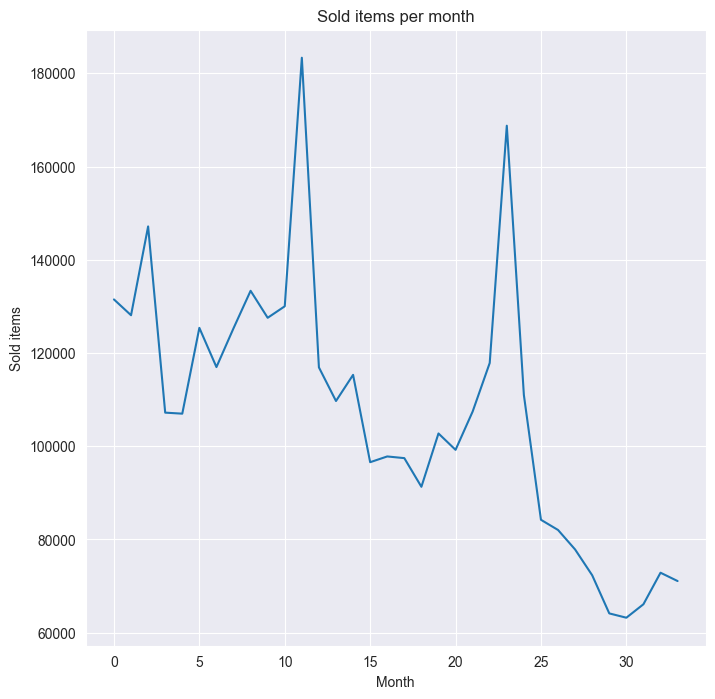

In [12]:
monthly_sales = df_train.groupby(["date_block_num"])["item_cnt_day"].sum().reset_index()
plt.figure(figsize=(8,8))
plt.title("Sold items per month")
plt.xlabel("Month")
plt.ylabel("Sold items")
sns.lineplot(data=monthly_sales, x="date_block_num", y="item_cnt_day")
plt.show()

### Top categories for a month

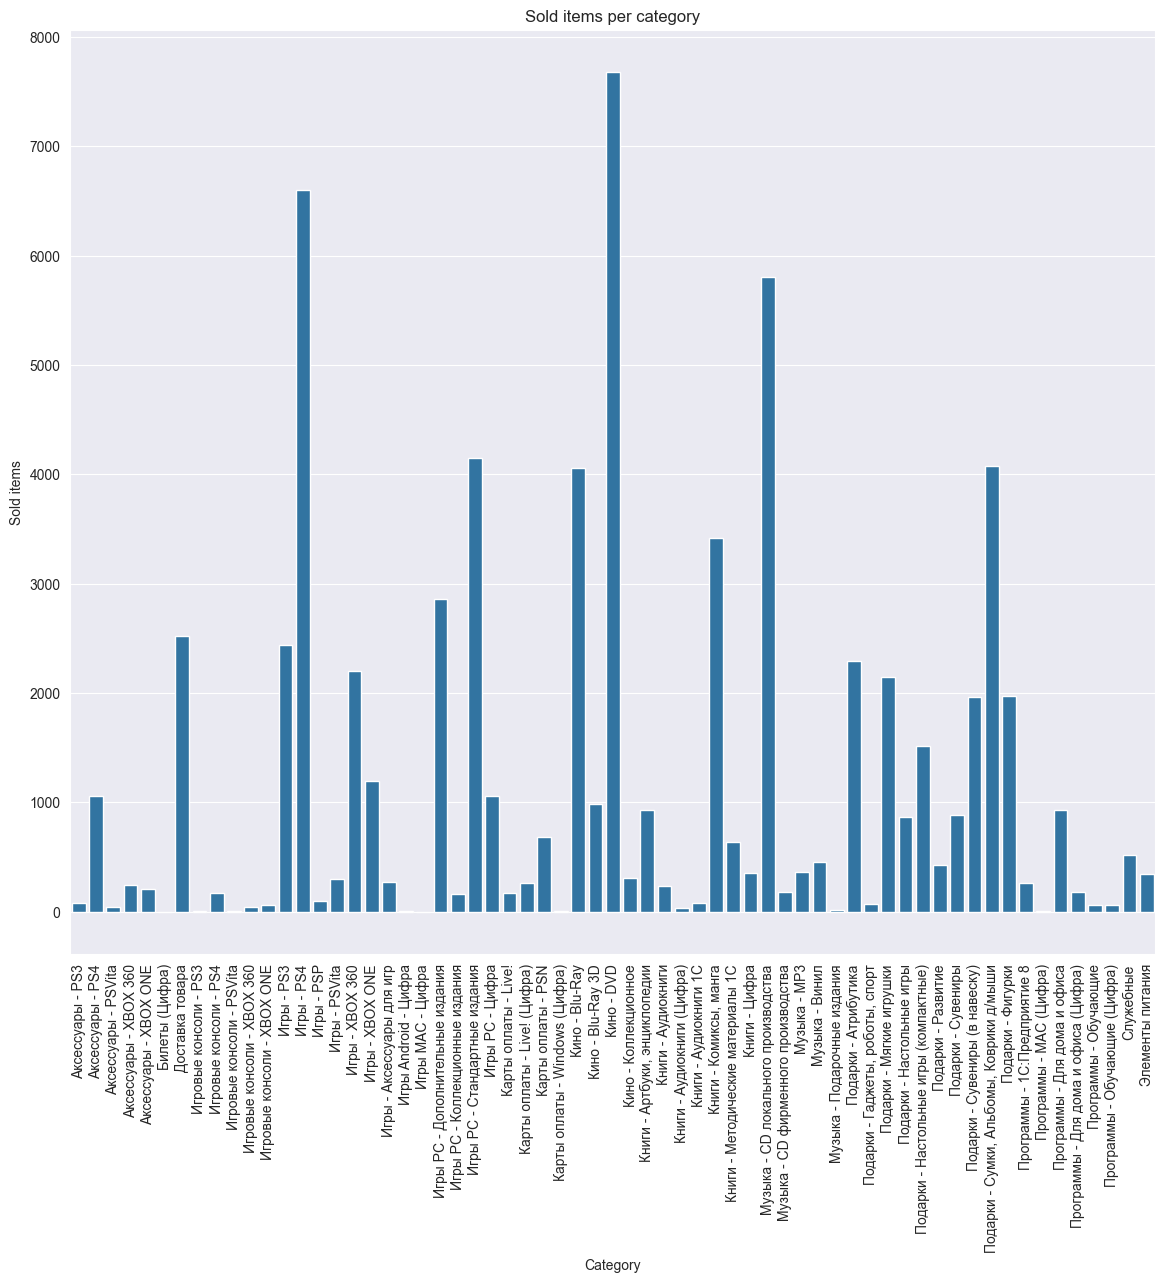

Top-10 categories:


,item_category_name,item_cnt_day
31,Кино - DVD,7680.0
13,Игры - PS4,6596.0
40,Музыка - CD локального производства,5808.0
23,Игры PC - Стандартные издания,4150.0
53,"Подарки - Сумки, Альбомы, Коврики д/мыши",4078.0
29,Кино - Blu-Ray,4061.0
37,"Книги - Комиксы, манга",3421.0
21,Игры PC - Дополнительные издания,2857.0
6,Доставка товара,2524.0
12,Игры - PS3,2443.0


In [84]:
month = 33
sales_per_category = df_train[df_train["date_block_num"] == month].groupby(["item_category_name"])["item_cnt_day"].sum().reset_index()
plt.figure(figsize=(14,12))
plt.title("Sold items per category")
plt.xlabel("Category")
plt.ylabel("Sold items")
sns.barplot(data=sales_per_category, x="item_category_name", y="item_cnt_day")
plt.xticks(rotation=90)
plt.show()

print("Top-10 categories:")
sales_per_category.nlargest(10, columns="item_cnt_day")

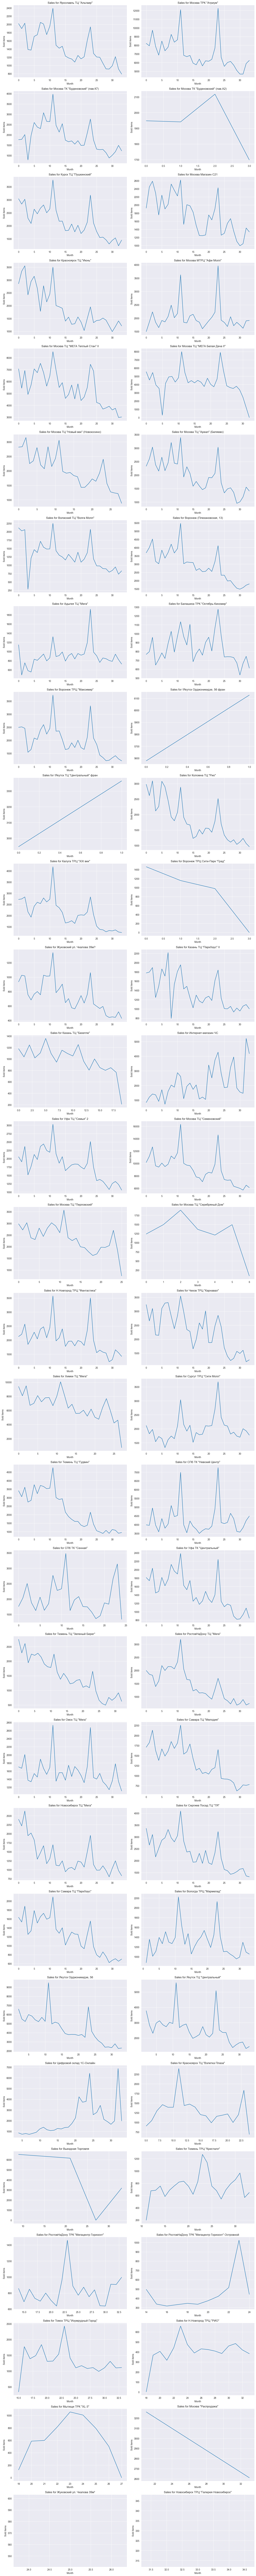

Top-10 shops:


shop_name
Москва ТЦ "Семеновский"            310777.0
Москва ТРК "Атриум"                241920.0
Химки ТЦ "Мега"                    185790.0
Москва ТЦ "МЕГА Теплый Стан" II    184557.0
СПб ТК "Невский Центр"             144934.0
Якутск Орджоникидзе, 56            141107.0
Москва ТЦ "МЕГА Белая Дача II"     136657.0
Воронеж (Плехановская, 13)         100489.0
Якутск ТЦ "Центральный"             81734.0
Сергиев Посад ТЦ "7Я"               78990.0
Name: item_cnt_day, dtype: float64

In [81]:
shops = df_train['shop_name'].unique()

num_shops = len(shops)
ncols = 2
nrows = (num_shops + ncols - 1) // ncols

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 5 * nrows))
axes = axes.flatten()

shops_monthly_sales = df_train.groupby(["date_block_num", "shop_name"])["item_cnt_day"].sum().reset_index()

for i, shop in enumerate(shops):
    shop_data = shops_monthly_sales[shops_monthly_sales['shop_name'] == shop]
    sns.lineplot(data=shop_data, x='date_block_num', y='item_cnt_day', ax=axes[i])

    axes[i].set_title(f'Sales for {shop}')
    axes[i].set_xlabel('Month')
    axes[i].set_ylabel('Sold items')

plt.tight_layout()
plt.show()

print("Top-10 shops:")
shops_monthly_sales.groupby("shop_name")["item_cnt_day"].sum().nlargest(10)

There are popular and unpopular shps. I think it depends on its location. Also, most plots show downtrend of sales, it proofs, it one more evidence for my observation about global downtrend of sales. There are 2 big peaks on a big part of plots, it shows that one or few products became popular in these periods, for example some popular game released, like GTA V or something like that. We need to add some news about spheres to predict peaks like these two.

### TOP-100 popular products for a month

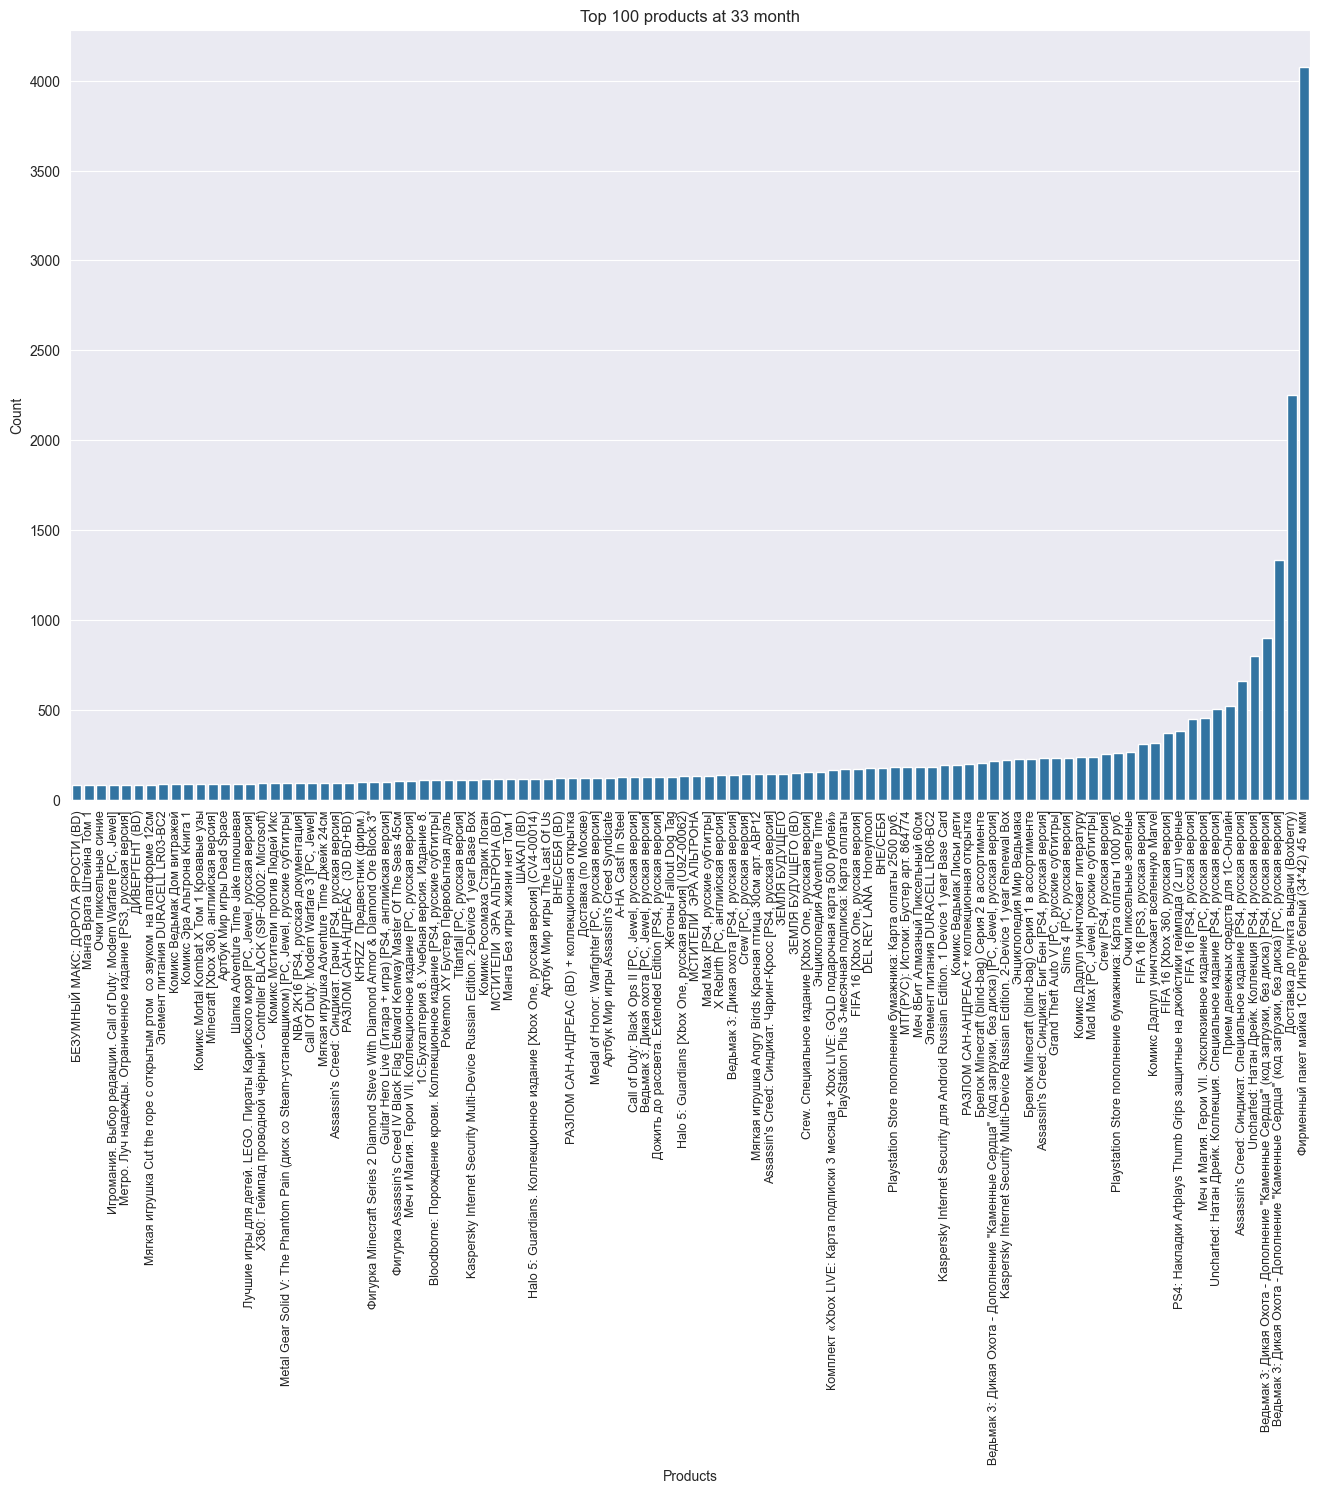

In [82]:
month = 33
top_100_products = df_train[df_train["date_block_num"] == month]
top_100_products = top_100_products.groupby(["date_block_num", "item_name"])["item_cnt_day"].sum().nlargest(100).reset_index()
top_100_products.sort_values(["item_cnt_day"], inplace=True)
plt.figure(figsize=(16, 10))
plt.title(f"Top 100 products at {month} month")
plt.xlabel("Products")
plt.ylabel("Count")
sns.barplot(data=top_100_products, x="item_name", y="item_cnt_day")
plt.xticks(rotation=90, fontsize=9)
plt.show()

### Trend, Seasonality, Irregular

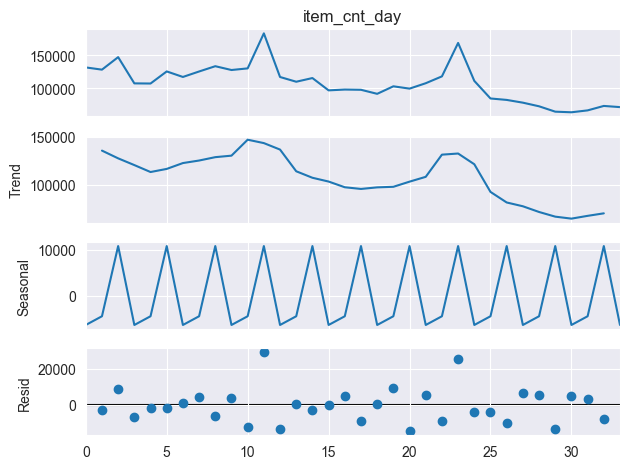

In [63]:
data_for_decomposition = pd.Series(monthly_sales["item_cnt_day"], index=monthly_sales["date_block_num"])
decomposition = seasonal_decompose(data_for_decomposition, model="add", period=3)
decomposition.plot()
plt.show()

### ACF and PACF

In [65]:
df_month = pd.DataFrame({"sales": monthly_sales["item_cnt_day"], "month": monthly_sales["date_block_num"]})
df_month.set_index("month", inplace=True)

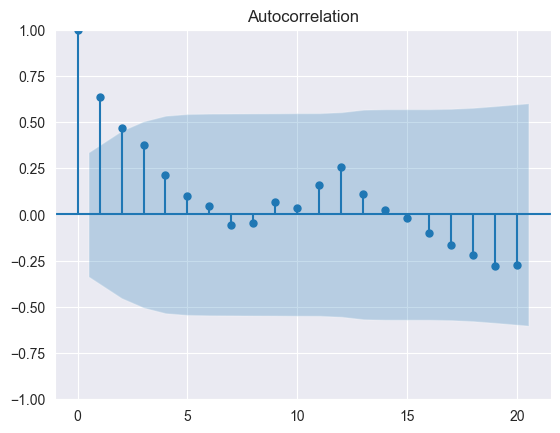

In [67]:
plot_acf(df_month["sales"], lags=20)
None

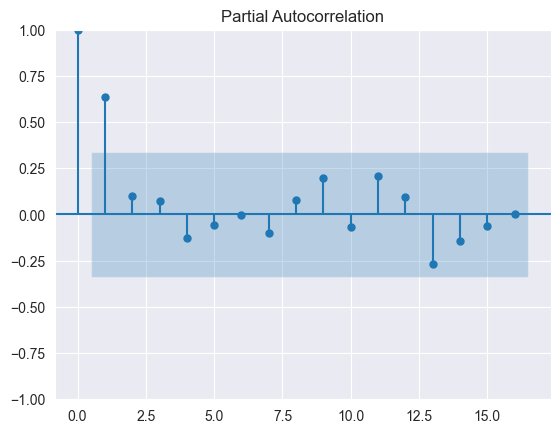

In [70]:
plot_pacf(df_month["sales"], lags=16)
None

## Pattern selection

It's time series predicting task, so time series components selecting is useful analyzing tool. As we can se plots shows downtrend, permanent seasonability and little irregular. it's a good news, because we can use models like SARIMA to predict monthly sales. But we need some mechanism to divide this sum into amount of products.

## Potential issues

As I described above, data has 22170 products, and it's impossible to build model for every product. Instead of it we can build one general model that can predict monthly sales over all products and then this sum will decompose into products via another model. Outliers, we cannot to drop it, because it's common case in finance data, Instead of it we must find out its nature, for example holidays, sales, and other reasons.

## Manual Prediction

1. Trend and Seasonal Adjustment:

    The forecasting process starts by analyzing both short-term trends and long-term seasonal patterns. First, we calculate the average growth rate from the last two months to determine the recent sales momentum. This rate is then used to create an initial, trend-based sales projection for each product category. To refine this projection, we perform a seasonality analysis. This involves identifying and calculating the average difference between sales during a specific seasonal period and the preceding month. The resulting seasonal adjustment is then added to the trend-based projection, producing a more accurate, forward-looking category budget.

2. Proportional Allocation and Budget Distribution:

    With the adjusted category budget established, we apply a proportional allocation model. This step requires determining each product's historical sales weight-its average contribution to the total sales of its category. This weight acts as a distribution key. The final, seasonally-adjusted category budget is then distributed among the individual products by multiplying it by each product's historical weight. This ensures that the overall category growth is proportionally reflected in the new budget for each product.

3. Final Quantity Forecasting:

    The final step converts the forecasted budget into a practical sales quantity. By dividing each product's new budget by its current price, we arrive at a tangible and actionable forecast for the number of goods to be sold.

## Conclusion

Data's statistic shows **VERY** heavy right tail. There are categories and shops that have much more sold products then other. Also, there is more popular products, and the most popular one - batch. Plots of sales and Trend show **downtrend** of sales. Sales have seasonality, it helps to improve predictions in some time intervals. Time-series is a bit irregular, it means that time-series have a small white noise component. *ACF* and *PACF* plots show that every month depends only on a last one.